In [6]:
import folium
from IPython.display import display
import contextily as cx
import matplotlib.pyplot as plt
import math
import networkx as nx
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import ipywidgets as widgets
from sklearn.cluster import KMeans
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from shapely import LineString, Polygon
from shapely import MultiPolygon, unary_union
import networkx as nx
import random
import numpy as np
import osmnx as ox
import geopandas
from osmnx.utils_graph import graph_to_gdfs
import momepy
import geonetworkx as gnx
import shapely
from shapely.geometry import Point
from sklearn import cluster
import scipy
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import warnings

In [7]:
%matplotlib notebook
warnings.filterwarnings("ignore")

## Before merging with index

In [8]:
def load_data(Tripoli=True):
    '''
    return: processed Lebanon/Tripoli data based on request
    '''
    # if processed data exist in file, load corresponding Lebanon/Tripoli data
    if os.path.exists('Data/Unsupervised_GNN/1d_buildings_Tripoli.gpkg'):
        if Tripoli == True:
            gdf_buildings_Tripoli = gpd.read_file('Data/Unsupervised_GNN/1d_buildings_Tripoli.gpkg', driver='GPKG')
            gdf_streets_Tripoli = gpd.read_file('Data/Unsupervised_GNN/1e_streets_Tripoli.gpkg', driver='GPKG')
            gdf_streets_Tripoli = gdf_streets_Tripoli.set_index(['u', 'v', 'key'])
            gdf_streets_nodes_Tripoli = gpd.read_file('Data/Unsupervised_GNN/1f_streets_nodes_Tripoli.gpkg', driver='GPKG')
            
            return gdf_buildings_Tripoli, gdf_streets_Tripoli, gdf_streets_nodes_Tripoli
        
        else:
            gdf_buildings_Lebanon = gpd.read_file('Data/Unsupervised_GNN/1a_buildings_Lebanon.gpkg', driver='GPKG')
            gdf_streets_Lebanon = gpd.read_file('Data/Unsupervised_GNN/1b_streets_Lebanon.gpkg', driver='GPKG')
            gdf_streets_Lebanon = gdf_streets_Lebanon.set_index(['u', 'v', 'key'])
            gdf_streets_nodes_Lebanon = gpd.read_file('Data/Unsupervised_GNN/1c_streets_nodes_Lebanon.gpkg', driver='GPKG')
            
            return gdf_buildings_Lebanon, gdf_streets_Lebanon, gdf_streets_nodes_Lebanon
    
    # if processed data doesn't exist in file, load unprocessed data and apply functinos
    else:
        # load and clean buildings data
        gdf_unprocessed_buildings_Lebanon = gpd.read_file('Data/HOTOSM_Data/hotosm_lbn_buildings_gpkg/hotosm_lbn_buildings.gpkg')
        gdf_unprocessed_buildings_Lebanon = gdf_unprocessed_buildings_Lebanon.to_crs(epsg=3857)
        gdf_buildings_Lebanon = process_building_data(gdf_unprocessed_buildings_Lebanon, building_labels, building_add_labels)
        
        # load and clean road data
        gdf_streets_nodes_Lebanon, gdf_streets_Lebanon = load_road_data()
        
        # convert to desired crs
        gdf_streets_Lebanon = gdf_streets_Lebanon.to_crs(gdf_buildings_Lebanon.crs) 
        gdf_streets_nodes_Lebanon = gdf_streets_nodes_Lebanon.to_crs(gdf_buildings_Lebanon.crs) 
        gdf_reordered_streets_Lebanon = reorder_streets_geometry(gdf_streets_Lebanon, gdf_streets_nodes_Lebanon)
        
        gdf_buildings_Lebanon.to_file('Data/Unsupervised_GNN/1a_buildings_Lebanon.gpkg', driver='GPKG')
        gdf_reordered_streets_Lebanon.to_file('Data/Unsupervised_GNN/1b_streets_Lebanon.gpkg', driver='GPKG')
        gdf_streets_nodes_Lebanon.to_file('Data/Unsupervised_GNN/1c_streets_nodes_Lebanon.gpkg', driver='GPKG')
            
        # extract Tripoli portion
        gdf_buildings_Tripoli, gdf_streets_Tripoli, gdf_streets_nodes_Tripoli = extract_Tripoli_data(gdf_buildings_Lebanon, gdf_streets_Lebanon, gdf_streets_nodes_Lebanon)
        gdf_reordered_streets_Tripoli = reorder_streets_geometry(gdf_streets_Tripoli, gdf_streets_nodes_Tripoli)
        
        gdf_buildings_Tripoli.to_file('Data/Unsupervised_GNN/1d_buildings_Tripoli.gpkg', driver='GPKG')
        gdf_reordered_streets_Tripoli.to_file('Data/Unsupervised_GNN/1e_streets_Tripoli.gpkg', driver='GPKG')
        gdf_streets_nodes_Tripoli.to_file('Data/Unsupervised_GNN/1f_streets_nodes_Tripoli.gpkg', driver='GPKG')

        if Tripoli == True:
             return gdf_buildings_Tripoli, gdf_reordered_streets_Tripoli, gdf_streets_nodes_Tripoli
        else: 
            return gdf_buildings_Lebanon, gdf_reordered_streets_Lebanon, gdf_streets_nodes_Lebanon
 
  
def process_building_data(building_data, building_labels, building_add_labels):
    '''
    input: gdf of buildings, dictionaries for building labels
    return: cleaned gdf of buildings
    '''
    # drop irrelevant columns
    selected_features = ['osm_id', 'building:levels', 'building', 'office', 'geometry']
    reduced_gdf = building_data[selected_features]  # Create a new DataFrame with only the selected features
    
    # clean'building:levels'
    invalid_values = ['q', 'qq', 'multiple']
    condition = ~reduced_gdf['building:levels'].isin(invalid_values)  #delete those with non-valid building level entries
    cleaned_gdf = reduced_gdf[condition]
    
    # categorise 'building' labels 
    building_labels_mapping = {str(value): key for key, values in building_labels.items() for value in values} # map labels 
    building_add_labels_mapping = {str(value): key for key, values in building_add_labels.items() for value in values}
    cleaned_gdf.loc[:, 'mapped_building'] = reduced_gdf['building'].map(building_labels_mapping) # add new columns for mapped labels
    cleaned_gdf.loc[:, 'add_label_building'] = reduced_gdf['building'].map(building_add_labels_mapping)
    
    return cleaned_gdf

def load_road_data():
    '''
    return: gdfs for street network
    '''
    # import graph from osmnx
    G = ox.graph_from_place('Lebanon', network_type='drive')

    # convert to undirected graph
    G_undirected = G.to_undirected()

    # convert graph to gdf and remove false nodes
    gdf_streets_nodes_Lebanon, gdf_streets_Lebanon = ox.graph_to_gdfs(G_undirected, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

    # decide attributes to keep for computational efficiency
    gdf_streets_Lebanon = gdf_streets_Lebanon[['length', 'geometry', 'junction']]

    # create unique id for each street segment
    gdf_streets_Lebanon["nID"] = range(len(gdf_streets_Lebanon))  
    
    return gdf_streets_nodes_Lebanon, gdf_streets_Lebanon

def extract_Tripoli_data(gdf_buildings_Lebanon, gdf_streets_Lebanon, gdf_streets_nodes_Lebanon):
    '''
    input: gdf of buildings, gdfs of streets
    return: gdf of buildings within Tripoli, gdfs of streets within Tripoli
    '''
    # Load administrative boundaries (0: nation level, 1: subnation level etc)
    files = ['Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm0_cdr_20200810.shp',
            'Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm1_cdr_20200810.shp',
            'Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm2_cdr_20200810.shp',
            'Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm3_cdr_20200810.shp']
    gdf_boundary = ['boundary0', 'boundary1', 'boundary2', 'boundary3']

    for i in range(len(files)):
        gdf_boundary[i] = gpd.read_file(files[i])
        gdf_boundary[i] = gdf_boundary[i].to_crs(gdf_buildings_Lebanon.crs)

    # Rename columns of interest
    gdf_boundary_1 = gdf_boundary[1][['OBJECTID', 'admin1Name', 'admin1Pcod','geometry']]
    gdf_boundary_1 = gdf_boundary_1.rename(columns={'OBJECTID':'admin1ID'})
    gdf_boundary_2 = gdf_boundary[2][['OBJECTID', 'admin1Name', 'admin1Pcod','admin2Name', 'admin2Pcod', 'geometry']]
    gdf_boundary_2 = gdf_boundary_2.rename(columns={'OBJECTID':'admin2ID'})
    gdf_boundary_3 = gdf_boundary[3][['OBJECTID', 'admin1Name', 'admin1Pcod','admin2Name', 'admin2Pcod','admin3Name', 'admin3Pcod','geometry']]
    gdf_boundary_3 = gdf_boundary_3.rename(columns={'OBJECTID':'admin3ID'})

    # define boundary
    level3 = gdf_boundary_3
    level3_Tripoli = level3[level3['admin2Name'] == 'Tripoli']

    # extract buildings within boundary
    gdf_buildings_Tripoli = gdf_buildings_Lebanon.sjoin(gdf_boundary_3, how='left', predicate='within', rsuffix='admin')
    gdf_buildings_Tripoli = gdf_buildings_Tripoli[gdf_buildings_Tripoli['admin2Name']=='Tripoli']

    # extract streets within boundary
    gdf_streets_Tripoli = gdf_streets_Lebanon.sjoin(gdf_boundary_2[gdf_boundary_2['admin2Name'] == 'Tripoli'], how='inner', predicate='intersects', rsuffix='admin')
    gdf_streets_Tripoli.drop(columns=['index_admin'], inplace=True)
    
    node_ids = set(gdf_streets_Tripoli.index.get_level_values('u')).union(gdf_streets_Tripoli.index.get_level_values('v'))
    gdf_streets_nodes_Tripoli = gdf_streets_nodes_Lebanon[gdf_streets_nodes_Lebanon.index.isin(node_ids)]
    gdf_streets_nodes_Tripoli.index = gdf_streets_nodes_Tripoli.index.astype(str).str.strip()
    gdf_streets_nodes_Tripoli.index = gdf_streets_nodes_Tripoli.index.astype('int64')

    return gdf_buildings_Tripoli, gdf_streets_Tripoli, gdf_streets_nodes_Tripoli

def reorder_streets_geometry(gdf_streets, gdf_streets_nodes):
    '''
    input: gdfs of streets
    return: reordered gdf of street edge
    '''
    # form dictionary of nodes position
    node_position_mapping = {idx: row['geometry'].coords[0] for idx, row in gdf_streets_nodes.iterrows()}
    
    # check if linestring geometry start at position of first node, reverse linestring geometry if not
    gdf_reordered_streets_edges = gdf_streets.copy()
    for idx, row in gdf_reordered_streets_edges.iterrows():
        geometry = row['geometry']
        coords = geometry.coords
        start_coord, end_coord = coords[0], coords[-1]

        u, v = idx[0], idx[1]
        u_coord, v_coord = node_position_mapping[u], node_position_mapping[v]

        if start_coord != u_coord:
            gdf_reordered_streets_edges.at[idx, 'geometry'] = LineString(coords[::-1])
    
    return gdf_reordered_streets_edges

# creating buildings categories to better classify data
residential = ['residential', 'apartments', 'dormitory', 'terrace', 'detached', 'house', 'garage', 'cabin']
commercial = ['commercial', 'retail', 'retails', 'commercial_space_for_rent', 
                    'supermarket', 'restaurant', 'hotel', 'office']
agricultural = ['greenhouse', 'farm_auxiliary', 'farm', 'silo', 'cowshed', 'shed', 'barn' ]
institutional = ['mosque', 'cathedral', 'church', 'chapel', 'church;yes', 'monastery', 'basilica',
                       'civic', 'stadium', 'grandstand', 'townhall', 'public', 'bunker', 'train_station']
education = ['university', 'kindergarten', 'school']
health = ['hospital']
industrial = ['industrial', 'warehouse', 'storage_tank', 'construction', 'hangar', 'carport']
abandoned = ['abandoned', 'ruin', 'ruins', 'ruins;castle']
others = ['mixed_use', 'mixed_used', 'bulding', 'roof', 'tent', 'hut', 'gatehouse', 'gym', 
                'parking', 'library', 'service', 'yes', '', 'tower']
        
building_labels = {
    "residential" : residential,
    "commercial" : commercial,
    "agricultural" : agricultural,
    "institutional" : institutional,
    "health" : health,
    "industrial" : industrial,
    "abandoned" : abandoned,
    "others" : others
}

# additional labels for strategic buildings and buildings likely at additional risk
building_add_labels = {"risk" : ['apartments', 'hotel', 'dormitory', 'hotel', 'office', 'tower'] + industrial + abandoned,
                      "strategic" : institutional + education + health}
    

In [9]:
def step_grouping(gdf_buildings, gdf_streets, buffer1=5, shrink1=0.1):
    '''
    generate groups in which collapse of a building will likely affect other buildings within same group 
    
    input: gdf of buildings
           gdf of streets
           buffer parameter: controls distance between buildings for them to be grouped together in a block
           shrink parameter: controls how close the group geometry trace along buildings
    return: building gdf with added column for block_ID
            gdf with individual building tessellation
            gdf with blocks as entries
    '''
    # tessellation around each building
    gdf_buildings_grouped = gdf_buildings.copy()
    limit = momepy.buffered_limit(gdf_buildings_grouped, buffer=buffer1) 
    tessellation_individual = momepy.Tessellation(gdf_buildings_grouped, unique_id='osm_id', shrink=shrink1, limit=limit)

    # block tessellation taking street network into account 
    tessellation = tessellation_individual.tessellation
    snapped = momepy.extend_lines(gdf_streets, tolerance=200, target=tessellation, barrier=gdf_buildings_grouped)
    tessellation_block = momepy.Blocks(tessellation, snapped, gdf_buildings_grouped, 'block_ID', 'osm_id')

    # assign block ids to buildings and tessellation
    gdf_buildings_grouped['block_ID'] = tessellation_block.buildings_id
    tessellation['block_ID'] = tessellation_block.tessellation_id
    block = tessellation_block.blocks
    
    occupied_blocks_list = gdf_buildings_grouped['block_ID'].unique()
    occupied_blocks = block[block['block_ID'].isin(occupied_blocks_list)]
    
    gdf_buildings_grouped.to_file('Data/Unsupervised_GNN/2a_grouped_buildings_Tripoli.gpkg', driver='GPKG')
    occupied_blocks.to_file('Data/Unsupervised_GNN/2b_blocks_Tripoli.gpkg', driver='GPKG')
    
    return gdf_buildings_grouped, tessellation, occupied_blocks

In [10]:
def step_identify_connections(occupied_blocks, gdf_streets, buffer=10, shrink=0.1):
    '''
    identify connections between blocks in close proximity along same street
    
    input: gdf of blocks
           gdf of of streets

    return: tess for each block where intersection determines connections
            graph object with nodes as blocks and edges as connections
            list of connections
    '''
    blocks_tess = create_block_tessellation(occupied_blocks, gdf_streets, buffer=buffer, shrink=shrink)
    primary_connections = identify_primary_connections(blocks_tess)
    G_block = create_graph_blocks(blocks_tess, primary_connections)
    
    return blocks_tess, G_block, primary_connections
    

def create_block_tessellation(occupied_blocks, subregion_streets_gdf, buffer=15, shrink=0.1):
    '''
    input: gdf of blocks
           gdf of of streets

    return: tessellation for each block where both buffer around block geometry and street networks are accounted for
    '''
    # define enclosures for block tessellation taking into account street geometry
    limit = momepy.buffered_limit(occupied_blocks, buffer=buffer)
    enclosures = momepy.enclosures(subregion_streets_gdf, limit=gpd.GeoSeries([limit]), clip=occupied_blocks['geometry'].unary_union)

    # use limit to prevent features collapsing -> geometry with boundaries near enclosing streets
    blocks_tess = momepy.Tessellation(occupied_blocks, unique_id='block_ID', limit=enclosures, shrink=shrink).tessellation
    
    return blocks_tess
    
def identify_primary_connections(blocks_tess):
    '''
    input: tess for each blocks
    return: list of connections between blocks
    '''
    # Create a spatial index for computational efficiency
    sindex = blocks_tess.sindex

    primary_connections = []

    for index1, block1 in blocks_tess.iterrows():
        tess1 = block1['geometry']
        id1 = block1['block_ID']

        # Get the potential intersecting geometries using the spatial index
        possible_matches_index = list(sindex.intersection(tess1.bounds))

        # Filter out the actual intersecting geometries
        possible_matches = blocks_tess.iloc[possible_matches_index]
        actual_intersections = possible_matches[possible_matches.intersects(tess1)]

        # Store the IDs of intersecting geometries in the dictionary
        intersection_ids = actual_intersections['block_ID'].tolist()
        id2s = [id2 for id2 in intersection_ids if id2 > id1]

        if id2s != []:         
            for id2 in id2s:
                primary_connections.append([id1, id2])
        
    return primary_connections

def create_graph_blocks(blocks_tess, primary_connections):
    '''
    input: tess of blocks
           list of connections for blocks
    return: tess for each block where intersection determines connections
            graph object with nodes as blocks and edges as connections
    '''
    G_block = nx.Graph()

    for idx, row in blocks_tess.iterrows():  # use blocks tess to include all blocks
        block = row['block_ID']
        centroid = np.array([row['geometry'].centroid.xy]).squeeze()
        other_attr = row.drop(['block_ID'])

        G_block.add_node(block, pos=centroid, **other_attr)

    # Iterate through the rows in the GeoDataFrame to add edges based on block connections
    i = 1

    for connections in primary_connections:
        block1 = connections[0]
        block2 = connections[1]
        nID = f'connection{i}'
        i += 1
        G_block.add_edge(block1, block2, nID=nID)
        
    return G_block

## Merging with index

In [11]:
def step_assign_index_to_clusters(gdf_buildings_clustered, occupied_blocks):
    '''
    aggregate and assign unsoundness index to each block of buildings
    
    input: gdf of clustered buildings
           gdf with clusters as entries
    return: gdf of clustered buildings with index
            gdf with clusters as entries with aggregated index
    '''
    gdf_buildings_index = gpd.read_file('Data/Supervised_GNN/unprofiled_buildings_with_index_Tripoli.gpkg', driver='GPKG')

    # Append index to each entry in building gdf
    gdf_buildings_with_index = gdf_buildings_clustered[['osm_id', 'geometry','block_ID']].merge(gdf_buildings_index[['osm_id', 'est_index']], on='osm_id')
    gdf_buildings_with_index['area'] = gdf_buildings_with_index['geometry'].area
    gdf_buildings_with_index['weighted_index'] = gdf_buildings_with_index['area'] * gdf_buildings_with_index['est_index']

    # Aggregate index for each cluster via area weighting
    gdf_cluster_with_index = gdf_buildings_with_index.groupby('block_ID').agg({'weighted_index':'sum', 'area':'sum'}).reset_index()
    gdf_cluster_with_index['final_index'] = gdf_cluster_with_index['weighted_index'] / gdf_cluster_with_index['area']

    gdf_cluster_with_index = occupied_blocks.merge(gdf_cluster_with_index, on='block_ID')
    gdf_cluster_with_index.to_file('Data/Unsupervised_GNN/3a_clusters_with_index_Tripoli.gpkg', driver='GPKG')
    
    return gdf_buildings_with_index, gdf_cluster_with_index

In [12]:
def step_assign_index_to_streets(gdf_blocks_tess, gdf_cluster_with_index, gdf_streets_edges, threshold=30, buffer=10):
    '''
    aggregate and assign road disruption index to each road section - discretised and undiscretised
    
    input: tess for each cluster 
           gdf of clusters with aggregated index
           gdf of streets
           parameter threshold, buffer
    return: gdf of discretised streets nodes with spacing < threshold, with added column for nearby clusters and aggregated index
            gdf of discretised streets edges with length < threshold, with added column for aggregated index
    '''
    # append aggregated cluster index to gdf of tessellation
    blocks_for_streets_intersection = gdf_blocks_tess.merge(gdf_cluster_with_index[['block_ID', 'final_index']], on='block_ID')
    
    # generate discretised streets nodes and edges, assign nearby building clusters to street nodes
    discretised_streets_nodes, discretised_streets_edges = generate_nodes_edges_list(gdf_streets_edges, threshold=threshold)
    discretised_streets_nodes_with_index = assign_buildings_to_street_nodes(blocks_for_streets_intersection, discretised_streets_nodes, buffer=buffer)
    discretised_streets_edge_with_index, streets_edge_with_index = aggregate_streets_edges_index(discretised_streets_nodes_with_index, discretised_streets_edges, gdf_streets_edges)
    
    streets_edge_with_index.to_file('Data/Unsupervised_GNN/3b_streets_edges_with_index_Tripoli.gpkg', driver='GPKG')
    discretised_streets_edge_with_index.to_file('Data/Unsupervised_GNN/3c_discretised_streets_edges_with_index_Tripoli.gpkg', driver='GPKG')
    discretised_streets_nodes_with_index.to_file('Data/Unsupervised_GNN/3d_discretised_streets_nodes_with_index_Tripoli.gpkg', driver='GPKG')
    
    return streets_edge_with_index, discretised_streets_edge_with_index, discretised_streets_nodes_with_index

def generate_nodes_edges_list(gdf_streets_edges, threshold=30):
    '''
    input: gdf of streets
           parameter threshold
    return: gdf of discretised streets nodes with spacing < threshold
            gdf of discretised streets edges with length < threshold
    '''
    new_id = 0
    u_list, v_list, geom_list, edges_list, nodes_list, nID_list = [], [], [], [], [], []
    
    # iterate through street edges and discretise into segments with length below buffer
    for index, data in gdf_streets_edges.iterrows():
        start_id, end_id = index[0], index[1]
        geometry = data['geometry']
        nID = data['nID']
        points = geometry.coords

        for i in range(len(points)-1):
            start_point, end_point = points[i], points[i+1]
            geom_segment = LineString([start_point, end_point])
            num_segments = math.ceil(geom_segment.length / threshold) 

            for j in range(num_segments): 
                if num_segments == 1 and i == 0 and i == len(points)-2:
                    u = start_id
                    v = end_id
                elif i == 0 and j == 0:
                    new_id += 1
                    u = start_id
                    v = f'new{new_id}'
                elif i == len(points)-2 and j == num_segments - 1:
                    u = f'new{new_id}'
                    v = end_id
                else:
                    new_id += 1
                    u = f'new{new_id-1}'
                    v = f'new{new_id}'

                start_dist = j * threshold
                end_dist = (j+1) * threshold if j < num_segments - 1 else geom_segment.length
                substring = shapely.ops.substring(geom_segment, start_dist=start_dist, end_dist=end_dist) 

                u_list.append(u)
                v_list.append(v)
                geom_list.append(substring)
                nID_list.append(nID)

                nodes_list.append((u, gnx.Point(substring.coords[0])))
                nodes_list.append((v, gnx.Point(substring.coords[-1])))

    # create discretised edge gdf
    data = {'u': u_list, 'v': v_list, 'geometry':geom_list, 'nID':nID_list}
    discretised_streets_edges = gpd.GeoDataFrame(data, crs=gdf_streets_edges.crs)

    # create discretised node gdf
    nodes_list = list(set(nodes_list))
    columns = ['id', 'geometry']
    discretised_streets_nodes = gpd.GeoDataFrame(nodes_list, columns=columns, geometry='geometry')
    
    return discretised_streets_nodes, discretised_streets_edges

    
def assign_buildings_to_street_nodes(blocks_tess, discretised_streets_nodes, buffer=10):    
    '''
    for each building, identify nearby points on surrounding streets which will be affected by building collapse
    
    input: tess for each cluster 
           gdf of discretised street nodes
           parameter buffer
    return: gdf of discretised street nodes with added column of assigned clusters and aggregated index 
    '''
    # create buffered gdf 
    buffered_blocks = blocks_tess.copy()
    buffered_blocks['geometry'] = blocks_tess['geometry'].buffer(buffer)

    # identify intersection with buffered block
    discretised_streets_nodes.sindex
    buffered_blocks.sindex
    discretised_streets_nodes['block_ID'] = None
    discretised_streets_nodes['final_index'] = None
    
    # iterate through street nodes, use spatial index to find which entries in buffered gdf contain point
    for idx, point in discretised_streets_nodes.iterrows():
        possible_matches_index = list(buffered_blocks.sindex.intersection(point['geometry'].bounds))
        possible_matches = buffered_blocks.iloc[possible_matches_index]

        block_IDs = [buffer['block_ID'] for _, buffer in possible_matches.iterrows() if point['geometry'].within(buffer['geometry'])]
        final_indexes = [buffer['final_index'] for _, buffer in possible_matches.iterrows() if point['geometry'].within(buffer['geometry'])]
        
        # append assigned blocks to entry, and use maximum index as aggregated node index
        if block_IDs != []:
            discretised_streets_nodes.at[idx, 'block_ID'] = block_IDs
            discretised_streets_nodes.at[idx, 'final_index'] = np.max(final_indexes)
        
        if block_IDs == []:
            discretised_streets_nodes.at[idx, 'final_index'] = 0
            
    discretised_streets_nodes['block_ID'] = discretised_streets_nodes['block_ID'].astype(str)
    
    return discretised_streets_nodes

def aggregate_streets_edges_index(discretised_streets_nodes, discretised_streets_edges, gdf_streets_edges):
    '''
    derive road disruption index from its discretised version
    
    input: gdf of discretised streets nodes with added column for nearby clusters and aggregated index
           gdf of discretised streets edges
    return: gdf of discretised streets edges with added column for aggregated index 
            gdf of streets edges with added column for aggregated index 
    '''
    # obtain index from street nodes gdf based on start and end nodes for each edge
    edge_with_index = discretised_streets_edges.merge(discretised_streets_nodes[['id', 'final_index']], how='left', left_on='u', right_on='id')
    edge_with_index = edge_with_index.merge(discretised_streets_nodes[['id', 'final_index']], how='left', left_on='v', right_on='id', suffixes=('_start', '_end'))

    # aggregate overall unsoundness index for each edge via mean of start and end nodes
    edge_with_index['overall_unsoundness'] = (edge_with_index['final_index_start'] + edge_with_index['final_index_end'])/2
    
    # assign overall unsoundness index to reconnected edges
    grouped_edges = edge_with_index.dissolve(by='nID', aggfunc={'overall_unsoundness': 'max'})[['overall_unsoundness']]

    reconnected_edge_with_index = gdf_streets_edges.copy()
    reconnected_edge_with_index = reconnected_edge_with_index[['nID', 'length', 'geometry']]
    reconnected_edge_with_index = reconnected_edge_with_index.merge(grouped_edges, how='left', left_on='nID', right_index=True)

    return edge_with_index, reconnected_edge_with_index

## After merging with index

In [13]:
def load_admin_boundary(gdf):
    '''
    load administrative boundaries in Lebanon
    
    '''
    
    # Load administrative boundaries (0: nation level, 1: subnation level etc)
    files = ['Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm0_cdr_20200810.shp',
            'Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm1_cdr_20200810.shp',
            'Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm2_cdr_20200810.shp',
            'Data/HOTOSM_Data/lbn_adm_cdr_20200810/lbn_admbnda_adm3_cdr_20200810.shp']
    gdf_boundary = ['boundary0', 'boundary1', 'boundary2', 'boundary3']

    for i in range(len(files)):
        gdf_boundary[i] = gpd.read_file(files[i])
        gdf_boundary[i] = gdf_boundary[i].to_crs(gdf.crs)

    # Rename columns of interest
    gdf_boundary_1 = gdf_boundary[1][['OBJECTID', 'admin1Name', 'admin1Pcod','geometry']]
    gdf_boundary_1 = gdf_boundary_1.rename(columns={'OBJECTID':'admin1ID'})
    gdf_boundary_2 = gdf_boundary[2][['OBJECTID', 'admin1Name', 'admin1Pcod','admin2Name', 'admin2Pcod', 'geometry']]
    gdf_boundary_2 = gdf_boundary_2.rename(columns={'OBJECTID':'admin2ID'})
    gdf_boundary_3 = gdf_boundary[3][['OBJECTID', 'admin1Name', 'admin1Pcod','admin2Name', 'admin2Pcod','admin3Name', 'admin3Pcod','geometry']]
    gdf_boundary_3 = gdf_boundary_3.rename(columns={'OBJECTID':'admin3ID'})
    
    return gdf_boundary_1, gdf_boundary_2, gdf_boundary_3
    
def step_extract_Tripoli_primary_part(gdf_buildings_with_index, streets_edge_with_index, gdf_boundary_2):
    '''
    for input gdf, extract those that lie in the primary part of Tripoli
    
    '''
    # identify geometry of primary part of Tripoli
    Tripoli_multipolygon = gdf_boundary_2[gdf_boundary_2['admin2Name'] == 'Tripoli']
    Tripoli_polygons = Tripoli_multipolygon.explode(ignore_index=True)
    Tripoli_polygons['size'] = np.where(Tripoli_polygons.geometry.area == Tripoli_polygons.geometry.area.max(), 'big', 'small')
    primary_Tripoli_polygon = Tripoli_polygons[Tripoli_polygons['size']=='big']
    
    # extract level 3 admin area within primary part of Tripoli
    Tripoli_level3 = gdf_boundary_3[gdf_boundary_3['admin2Name'] == 'Tripoli']
    labelled_Tripoli_level3 = gpd.sjoin(Tripoli_level3, primary_Tripoli_polygon[['geometry', 'size']], how='left', predicate='within')
    primary_Tripoli_level3 = labelled_Tripoli_level3[labelled_Tripoli_level3['size']=='big']
    
    # extract buildings within Tripoli primary part
    buildings_with_index_primary = gdf_buildings_with_index.sjoin(primary_Tripoli_polygon, how='inner', predicate='intersects')
    
    # extract street edges within Tripoli primary part
    streets_edge_with_index['length'] = streets_edge_with_index['geometry'].length
    streets_edge_with_index_primary = streets_edge_with_index.sjoin(primary_Tripoli_polygon, how='inner', predicate='intersects')
    streets_edge_with_index_primary = streets_edge_with_index_primary[['nID', 'length', 'geometry', 'overall_unsoundness']]
    streets_edge_with_index_primary['connectivity'] = 1/streets_edge_with_index_primary['length']
    
    # append attribute 'level 3 admin' to streets 
    admin_boundary = primary_Tripoli_level3[['admin3ID', 'geometry']]
    streets_edges_with_subadmin_primary = gpd.overlay(streets_edge_with_index_primary, admin_boundary, how='intersection')

    buildings_with_index_primary.to_file('Data/Unsupervised_GNN/4a_buildings_with_index_primary_Tripoli.gpkg', driver='GPKG')
    streets_edge_with_index_primary.to_file('Data/Unsupervised_GNN/4b_streets_edge_with_index_primary_Tripoli.gpkg', driver='GPKG')

    return primary_Tripoli_polygon, admin_boundary, buildings_with_index_primary, streets_edge_with_index_primary, streets_edges_with_subadmin_primary

## Street level analysis

### Road Disruption Index

In [14]:
def visualise_road_disruption_index(streets_edge_with_index_primary, primary_Tripoli_polygon):
    '''
    visualise distribution of road disruption index which has been derived from building unsoundness index
    '''
    
    cmap='coolwarm'
    csfont = {'fontname':'Times New Roman'}
    fig, ax = plt.subplots(figsize=(6, 6))

    streets_edge_with_index_primary.plot(ax=ax, column='overall_unsoundness', linewidth=1, cmap=cmap)
    primary_Tripoli_polygon.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, zorder=-1)

    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), orientation='vertical', ax=ax)
    plt.title('Road disruption index achieved over Tripoli', fontsize=17, **csfont)

    ax.set_axis_off()
    plt.savefig('Results/Road disruption index.png')
    plt.show()

### Street betweenness

In [15]:
def step_threshold_case(edge_gdf, threshold):
    '''
    remove streets above threshold index i.e., assumed to be blocked by nearby buildings collapses
    
    '''
    gdf = remove_unsoundness_above_threshold(edge_gdf, threshold)
    G_streets = construct_graph_from_streets_edges(gdf)
    return gdf, G_streets

def remove_unsoundness_above_threshold(edge_gdf, threshold):
    gdf = edge_gdf.copy()
    gdf = gdf[gdf['overall_unsoundness']<threshold]
    return gdf

def construct_graph_from_streets_edges(gdf):
    streets = [(idx[0], idx[1], dict(geometry=row['geometry'], unsoundness=row['overall_unsoundness'], connectivity=row['connectivity'])) for idx, row in gdf.iterrows()]
    G_streets = gnx.GeoGraph(crs=gdf.crs)
    G_streets.add_edges_from(streets)
    
    return G_streets 

def compute_streets_centralities(streets_edge_with_index_primary, threshold):
    edges_threshold, G_streets_threshold = step_threshold_case(streets_edge_with_index_primary, threshold)
    primal = momepy.gdf_to_nx(edges_threshold, approach='primal')
    primal = momepy.betweenness_centrality(primal, name='edges_betweenness', mode='edges', weight='length')

    primal_gdf = momepy.nx_to_gdf(primal, points=False)
    
    return primal_gdf

def pos(G):
    pos = nx.get_node_attributes(G, 'geometry')
    for i in pos:
        point = pos[i]
        array = np.array([point.x, point.y])
        pos[i] = array
    return pos

def generate_primal(streets_edge_with_index_primary):
    '''
    compute road centralities in each scenario
    
    '''
    threshold0, threshold1, threshold2 = 1.0, 0.695, 0.685
    primal_gdf_0 = compute_streets_centralities(streets_edge_with_index_primary, threshold0)
    primal_gdf_1 = compute_streets_centralities(streets_edge_with_index_primary, threshold1)
    primal_gdf_2 = compute_streets_centralities(streets_edge_with_index_primary, threshold2)
    
    primal_list = [primal_gdf_0, primal_gdf_1, primal_gdf_2]
    
    return primal_list



In [16]:
def visualise_critical_roads(threshold=0):
    '''
    visualise streets with high road disruption index in each scenario
    
    '''
    
    centrality = 'edges_betweenness'
    title = 'edge_betweenness'

    selected_primal = primal_list[threshold]

    f, ax = plt.subplots(figsize=(6, 6))
    csfont = {'fontname':'Times New Roman'}

    selected_primal.plot(ax=ax, column=centrality, cmap='Spectral_r',  linewidth=0.1+selected_primal[centrality]*20, scheme='quantiles', k=15, alpha=0.6, zorder=1)
    primary_Tripoli_polygon.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, zorder=-1)

    ax.set_title(f'Critical roads in disaster route planning and network restoration (Scenario {threshold})',fontsize=10, **csfont)
    ax.set_axis_off()
    
    plt.savefig(f'Results/Critical Roads (Scenario{threshold}).png')
    plt.show()

## Cluster level analysis

In [17]:
def cluster_graph(G_streets_threshold, min_eigenvalue=1e-4):
    '''
    apply spectral clustering to obtain zone distribution based on road connectivity patterns
    '''

    disconnected_components = list(nx.connected_components(G_streets_threshold))
    node_to_component = {}
    node_to_cluster = {}

    for component_idx, component in enumerate(disconnected_components):
        subgraph = G_streets_threshold.subgraph(component)
        L = nx.laplacian_matrix(subgraph, weight='connectivity').toarray()
        eigenvalues, eigenvectors = np.linalg.eigh(L)

        if eigenvalues[1] < min_eigenvalue:   
            zero_start = np.searchsorted(eigenvalues, 0, side='left') 
            eigengap = np.diff(eigenvalues[eigenvalues < min_eigenvalue])
            cluster_end = np.argmax(eigengap) + 1
            
            if zero_start != cluster_end:
                selected_eigenvectors = eigenvectors[:, zero_start:cluster_end]
                num_clusters = selected_eigenvectors.shape[1]
                kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
                clusters = kmeans.fit_predict(selected_eigenvectors)
                subgraph_labels = [f"{component_idx}_{label}" for label in clusters]
            else:
                num_clusters = 1
                subgraph_labels = [f"{component_idx}_1" for _ in subgraph.nodes()]

        else:
            num_clusters = 1
            subgraph_labels = [f"{component_idx}_1" for _ in subgraph.nodes()]
        
        
        for idx, node in enumerate(subgraph.nodes()):
            node_to_cluster[node] = subgraph_labels[idx]

        for node in component:
            node_to_component[node] = component_idx
    
    return node_to_component, node_to_cluster

def color(node_to_cluster, edges_threshold, G_streets_threshold):
    unique_clusters = set(node_to_cluster.values())
    num_cluster = len(unique_clusters)
    colors = [cm.hsv(i/num_cluster) for i in range(num_cluster)]
    cluster_to_color = {label: colors[i % len(colors)] for i, label in enumerate(sorted(unique_clusters))}
    cluster_to_color['intercluster'] = (0.0, 0.0, 0.0, 1.0)
    
    cluster_unsoundness_sum = {cluster: 0 for cluster in set(node_to_cluster.values())}
    cluster_edge_count = {cluster: 0 for cluster in set(node_to_cluster.values())}
    
    edges_threshold['cluster'] = None
    for idx, row in edges_threshold.iterrows():
            if node_to_cluster[idx[0]] == node_to_cluster[idx[1]]:
                edges_threshold.at[idx, 'cluster'] = node_to_cluster[idx[0]]
            else:
                edges_threshold.at[idx, 'cluster'] = 'intercluster'
                unsoundness = row['overall_unsoundness']
                
                cluster_unsoundness_sum[node_to_cluster[idx[0]]] += unsoundness
                cluster_unsoundness_sum[node_to_cluster[idx[1]]] += unsoundness
                cluster_edge_count[node_to_cluster[idx[0]]] += 1
                cluster_edge_count[node_to_cluster[idx[1]]] += 1
                
            edges_threshold['color'] = edges_threshold['cluster'].map(cluster_to_color)
    
    cluster_avg_unsoundness = {cluster: cluster_unsoundness_sum[cluster] / cluster_edge_count[cluster] if cluster_edge_count[cluster] > 0 else 1.0 for cluster in cluster_unsoundness_sum}
    node_color_list = [cluster_to_color[node_to_cluster[node]] for node in G_streets_threshold.nodes()]
    
    cluster_by_edges = edges_threshold.groupby('cluster').agg({'length':'sum', 'nID':'unique', 'geometry':unary_union, 'cluster':'first', 'color':'first'})
    cluster_by_edges = gpd.GeoDataFrame(cluster_by_edges, geometry=cluster_by_edges['geometry'], crs=edges_threshold.crs)
    
    cluster_by_edges = cluster_by_edges[cluster_by_edges.index != 'intercluster']
    
    
    return edges_threshold, node_color_list, cluster_to_color, cluster_avg_unsoundness, cluster_by_edges

def compute_cluster_centralities(edges_threshold, cluster_by_edges, node_to_cluster):
    '''
    compute cluster level centralities in each scenario
    '''

    edges_connecting_clusters = edges_threshold[edges_threshold['cluster']=='intercluster']

    G_cluster = nx.MultiGraph()

    cluster_nodes_pos = {idx: (row['geometry'].centroid.x, row['geometry'].centroid.y)  for idx, row in cluster_by_edges.iterrows()}

    G_cluster.add_nodes_from(cluster_by_edges.index)
    nx.set_node_attributes(G_cluster, cluster_nodes_pos, 'pos')

    for index, row in edges_connecting_clusters.iterrows():
        u, v = node_to_cluster[index[0]], node_to_cluster[index[1]]
        d = {'nID':row['nID'], 'geometry':row['geometry'], 
         'connectivity':row['connectivity'], 
         'overall_unsoundness':row['overall_unsoundness'],
            'color': row['color']}

        G_cluster.add_edge(u, v, key=row['nID'], **d)

    betweenness_centrality = nx.betweenness_centrality(G_cluster, weight=None, normalized=True, seed=10)
    cluster_by_edges['betweenness_centrality'] = cluster_by_edges.index.map(betweenness_centrality)
    
    return cluster_by_edges, edges_connecting_clusters

def inter_cluster_unsoundness_threshold(streets_edge_with_index_primary, threshold, min_eigenvalue=1e-4):
    edges_threshold, G_streets_threshold = step_threshold_case(streets_edge_with_index_primary, threshold)
    node_to_component, node_to_cluster = cluster_graph(G_streets_threshold, min_eigenvalue=min_eigenvalue)
    edges_threshold, node_color_list, cluster_to_color, cluster_avg_unsoundness, cluster_by_edges = color(node_to_cluster, edges_threshold, G_streets_threshold)
    cluster_by_edges = cluster_by_edges[cluster_by_edges.index != 'intercluster']
    cluster_by_edges['avg_inter_unsoundness'] = cluster_avg_unsoundness
    
    cluster_by_edges, edges_connecting_clusters = compute_cluster_centralities(edges_threshold, cluster_by_edges, node_to_cluster)
    
    return cluster_by_edges, edges_connecting_clusters, edges_threshold, G_streets_threshold


In [18]:
def generate_polygon(gdf):
    '''
    generate polygon surrounding each cluster to aid visualisation
    '''
    combined_list = []

    for index, group in gdf.iterrows():
        geometry = group['geometry']
        
        if isinstance(geometry, LineString):
            poly, cuts, dangles, invalid = shapely.polygonize_full([geometry])
            lines = cuts.union(dangles)
            combined = poly.union(lines)
        else:
            linestring_array = np.array(geometry.geoms)
            poly, cuts, dangles, invalid = shapely.polygonize_full(linestring_array)
            lines = cuts.union(dangles)
            combined = poly.union(lines)

        combined_list.append(combined)

    gdf_polygon = gpd.GeoDataFrame(gdf, geometry=combined_list, crs=gdf.crs)
    
    return gdf_polygon

def generate_cluster_scenarios(streets_edge_with_index_primary):
    
    threshold0, threshold1, threshold2 = 1.0, 0.695, 0.685
    cluster_by_edges0, edges_connecting_clusters0, edges_threshold0, G_streets_threshold0 = inter_cluster_unsoundness_threshold(streets_edge_with_index_primary, threshold0, min_eigenvalue=9e-5)
    cluster_by_edges1, edges_connecting_clusters1, edges_threshold1, G_streets_threshold1 = inter_cluster_unsoundness_threshold(streets_edge_with_index_primary, threshold1, min_eigenvalue=9e-5)
    cluster_by_edges2, edges_connecting_clusters2, edges_threshold2, G_streets_threshold2 = inter_cluster_unsoundness_threshold(streets_edge_with_index_primary, threshold2, min_eigenvalue=9e-5)

    scenario0_polygon = generate_polygon(cluster_by_edges0)
    scenario1_polygon = generate_polygon(cluster_by_edges1)
    scenario2_polygon = generate_polygon(cluster_by_edges2)
    
    gdfs = [cluster_by_edges0, cluster_by_edges1, cluster_by_edges2]
    polygon_gdfs = [scenario0_polygon, scenario1_polygon, scenario2_polygon]
    edges_gdfs = [edges_connecting_clusters0, edges_connecting_clusters1, edges_connecting_clusters2]
   
    
    return gdfs, polygon_gdfs, edges_gdfs

In [19]:
def visualise_cluster_betweenness(threshold):

    measure = 'betweenness_centrality'

    selected_gdf = gdfs[threshold].copy()
    selected_polygon = polygon_gdfs[threshold].copy()
    selected_gdf[measure] += 1e-9
    selected_polygon[measure] += 1e-9


    cmap='Spectral_r'

    f, ax = plt.subplots(figsize=(6, 6))
    streets_edge_with_index_primary.plot(ax=ax, color='grey', alpha=0.4, zorder=-2)
    edges_gdfs[threshold].plot(ax=ax, color='darkgrey', zorder=-1)
    selected_polygon.plot(ax=ax, column=measure, cmap=cmap, norm=LogNorm(vmin=0.01, vmax=1), alpha=0.7, zorder=-1)
    selected_gdf.plot(ax=ax, column=measure, cmap=cmap, norm=LogNorm(vmin=0.01, vmax=1), zorder=1, legend=True)

    primary_Tripoli_polygon.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, zorder=-2)

    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=0.01, vmax=1))
    ax.set_title(f'Cluster Betweenness Centrality (Scenario {threshold})')
    ax.set_axis_off()
    
    plt.savefig(f'Results/Cluster Betweenness Centrality (Scenario{threshold}).png')
    plt.show()

# Run code

In [20]:
# Before merging with index
gdf_buildings_Tripoli, gdf_streets_Tripoli, gdf_streets_nodes_Tripoli = load_data(Tripoli=True)
gdf_buildings_clustered, tessellation, occupied_blocks = step_grouping(gdf_buildings_Tripoli, gdf_streets_Tripoli, buffer1=5, shrink1=0.1)
gdf_blocks_tess, G_buildings_block, primary_connections = step_identify_connections(occupied_blocks, gdf_streets_Tripoli, buffer=10, shrink=0.1)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...
Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [21]:
# Merging with index
gdf_buildings_with_index, gdf_cluster_with_index = step_assign_index_to_clusters(gdf_buildings_clustered, occupied_blocks)
streets_edge_with_index, discretised_streets_edge_with_index, discretised_streets_nodes_with_index = step_assign_index_to_streets(gdf_blocks_tess, gdf_cluster_with_index, gdf_streets_Tripoli, threshold=30, buffer=10)

In [22]:
# After merging with index
gdf_boundary_1, gdf_boundary_2, gdf_boundary_3 = load_admin_boundary(streets_edge_with_index)
primary_Tripoli_polygon, primary_Tripoli_level3, buildings_with_index_primary, streets_edge_with_index_primary, streets_edges_with_subadmin_primary = step_extract_Tripoli_primary_part(gdf_buildings_with_index, streets_edge_with_index, gdf_boundary_2)
primary_Tripoli_polygon, admin_boundary, buildings_with_index_primary, discretised_streets_edge_with_index_primary, discretised_streets_edges_with_subadmin_primary = step_extract_Tripoli_primary_part(gdf_buildings_with_index, discretised_streets_edge_with_index, gdf_boundary_2)

<IPython.core.display.Javascript object>


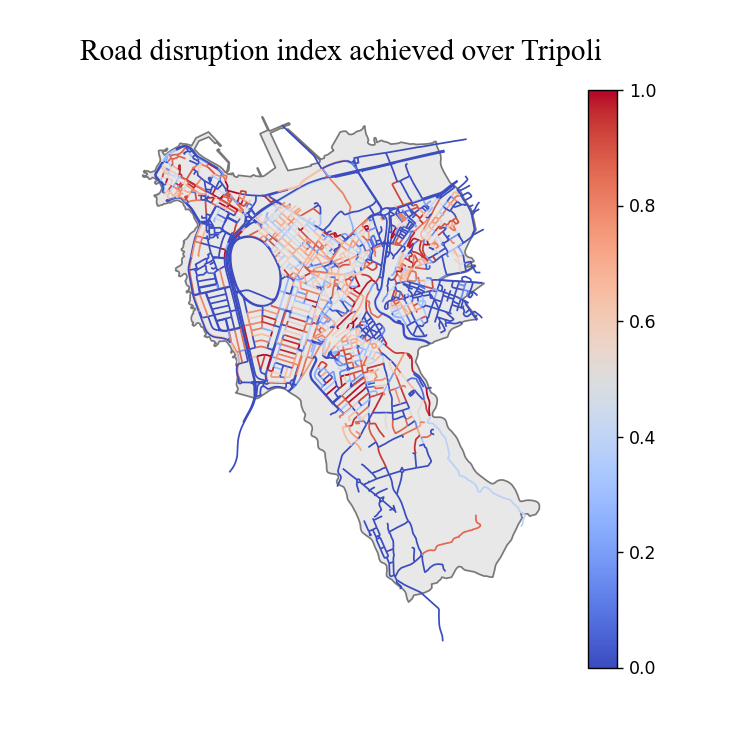

In [23]:
visualise_road_disruption_index(streets_edge_with_index_primary, primary_Tripoli_polygon)

In [24]:
# compute road centralities in each scenario
primal_list = generate_primal(streets_edge_with_index_primary)

<IPython.core.display.Javascript object>


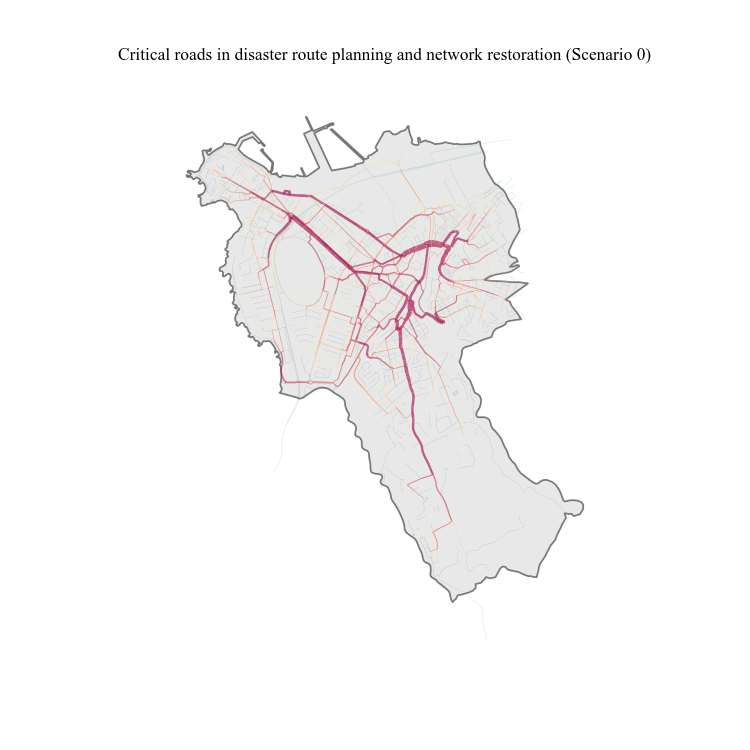

<IPython.core.display.Javascript object>


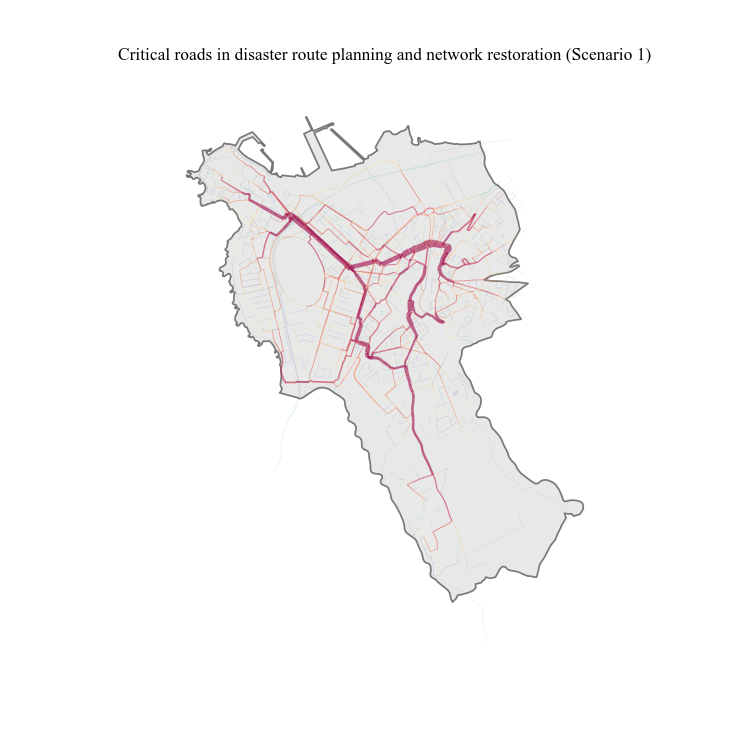

<IPython.core.display.Javascript object>


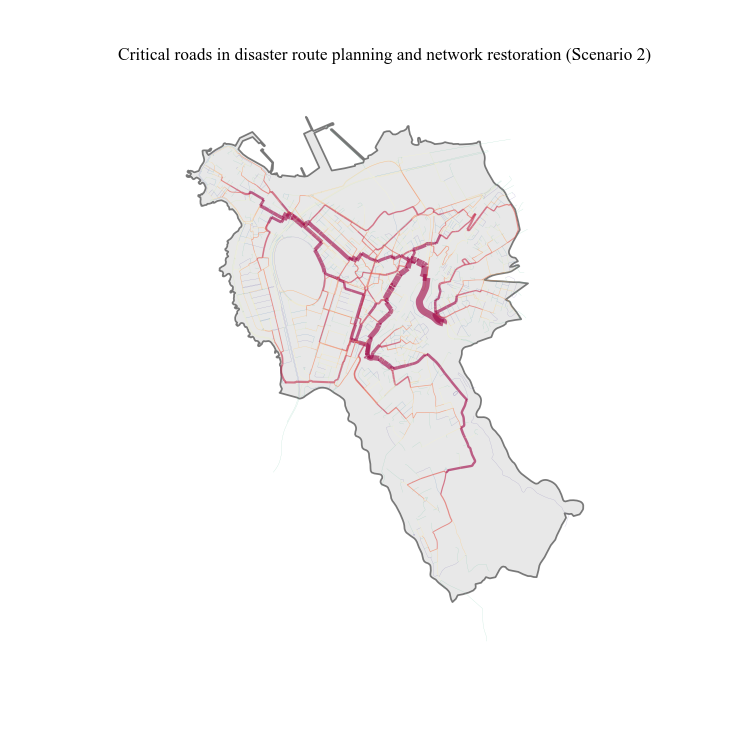

In [25]:
for threshold in range(3):
    visualise_critical_roads(threshold)

In [26]:
# compute cluster centralities in each scenario

gdfs, polygon_gdfs, edges_gdfs = generate_cluster_scenarios(streets_edge_with_index_primary)

<IPython.core.display.Javascript object>


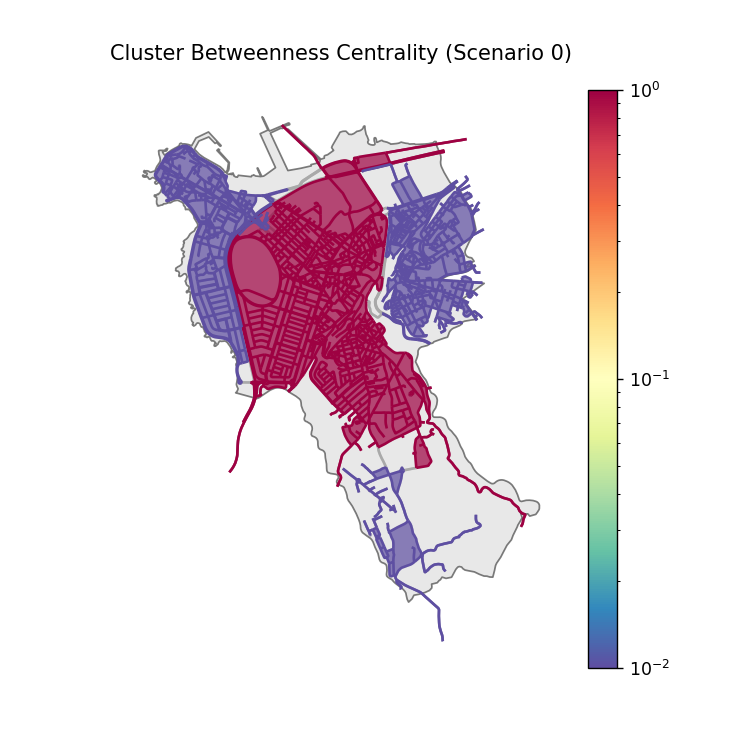

<IPython.core.display.Javascript object>


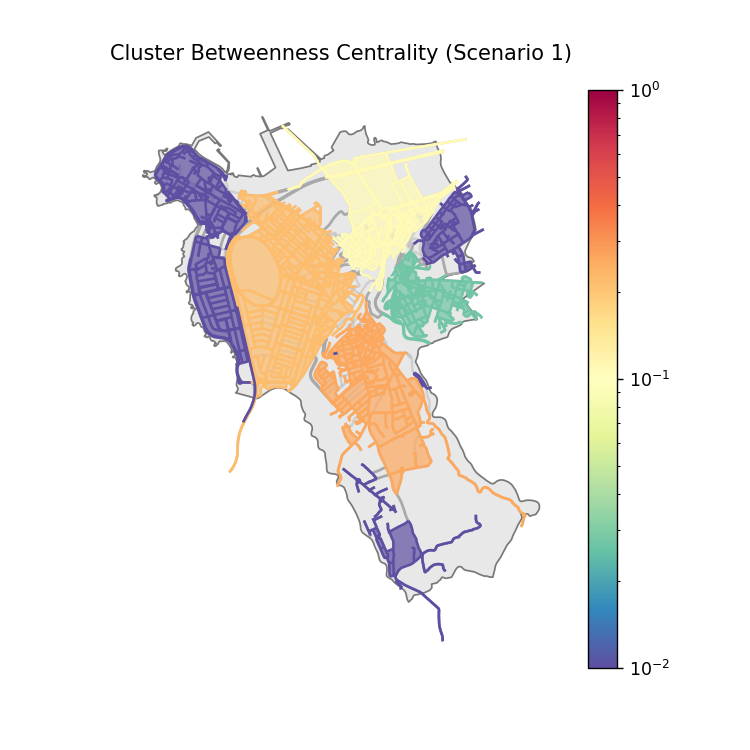

<IPython.core.display.Javascript object>


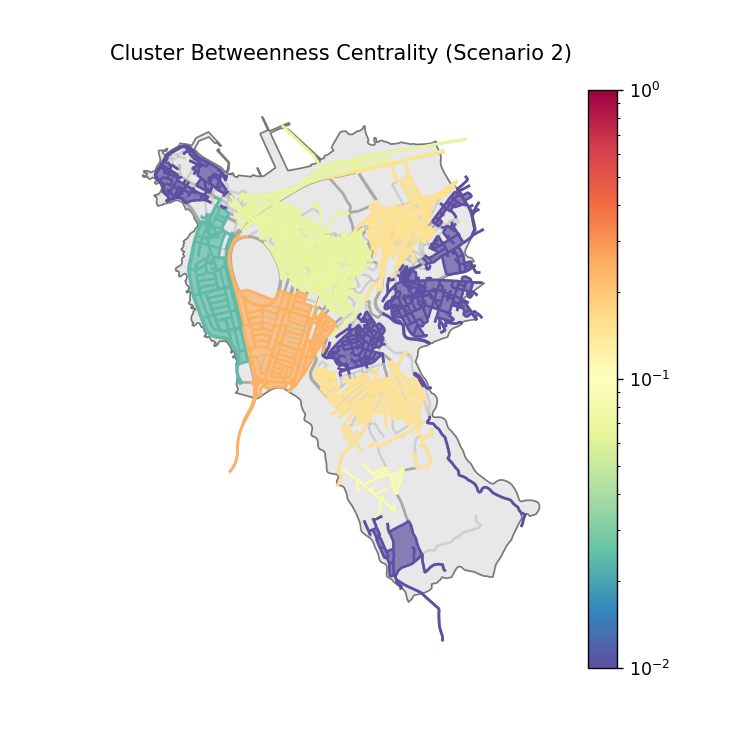

In [27]:
for threshold in range(3):
    visualise_cluster_betweenness(threshold)